# Name: Ahmed Mohiuddin Shah
# CMS ID: 415216
# Section: BSCS-12-A
# Assignment: 3
# Subject: Machine Learning
# Submitted to: Dr. Muhammad Moazam Fraz

# Library Imports

In [40]:
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from node2vec import Node2Vec
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh

In [20]:
dataset_paths = [
    "dataset/0.edges",
    "dataset/107.edges",
    "dataset/348.edges",
    "dataset/414.edges",
    "dataset/686.edges",
    "dataset/698.edges",
    "dataset/1684.edges",
    "dataset/1912.edges",
    "dataset/3437.edges",
    "dataset/3980.edges",
    "facebook_combined.txt",
]

# Dataset Exploration and Graph Construction

In [21]:
def load_graph(graph_file, plot_graph=True):
    G = nx.read_edgelist(graph_file, nodetype=int, create_using=nx.Graph())

    if plot_graph:
        # using spring layout
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G)

        node_color = [20000.0 * G.degree(v) for v in G]

        nx.draw_networkx(
            G,
            pos,
            with_labels=False,
            node_color=node_color,
            node_size=200,
            cmap=plt.cm.rainbow,
        )
        plt.show()

    return G

## Loading the Dataset

#### Unzipping the Dataset

In [22]:
# unzipping the file
with gzip.open('facebook_combined.txt.gz', 'rb') as f_in:
    with open('facebook_combined.txt', 'wb') as f_out:
        f_out.write(f_in.read())

### Loading the Edge List

Loading graph from dataset/0.edges


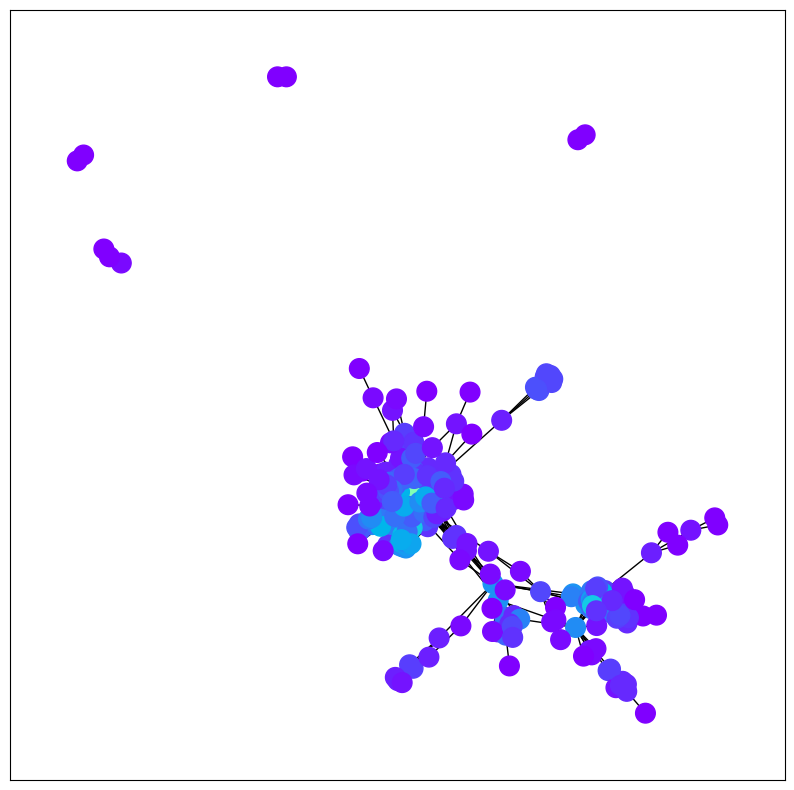

Loading graph from dataset/107.edges


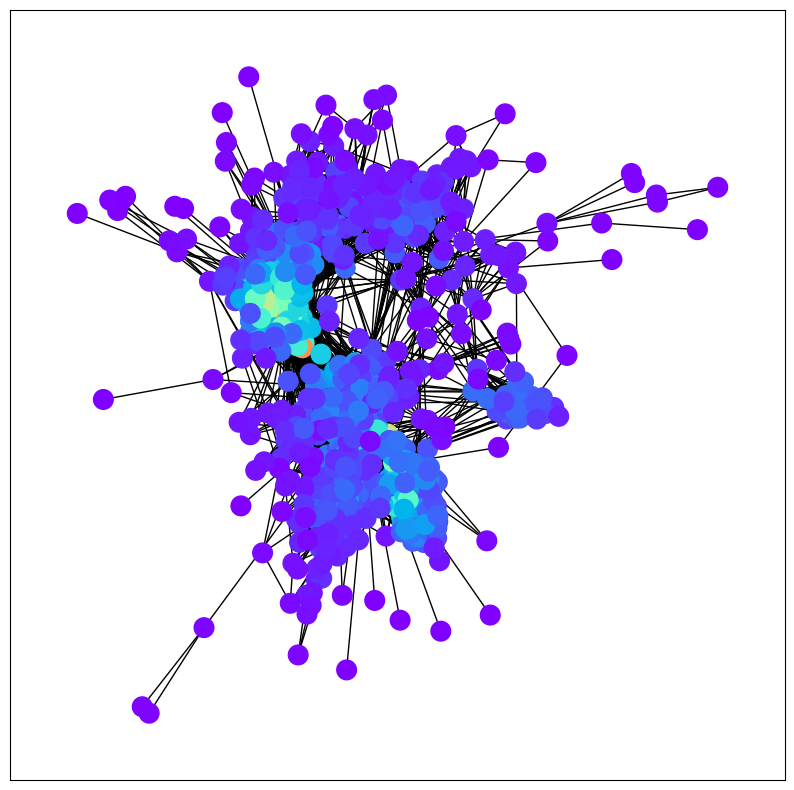

Loading graph from dataset/348.edges


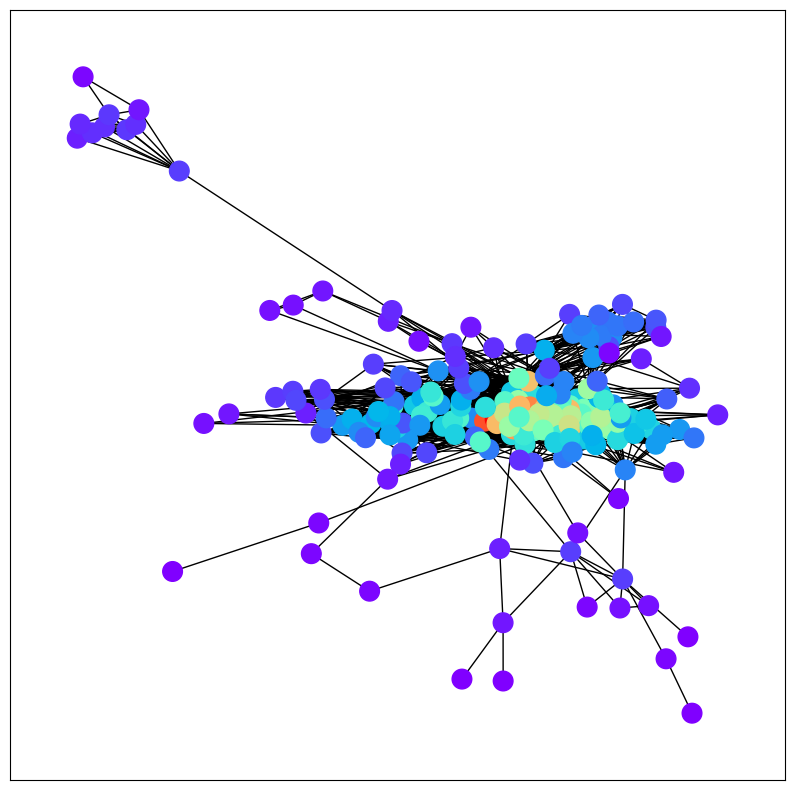

Loading graph from dataset/414.edges


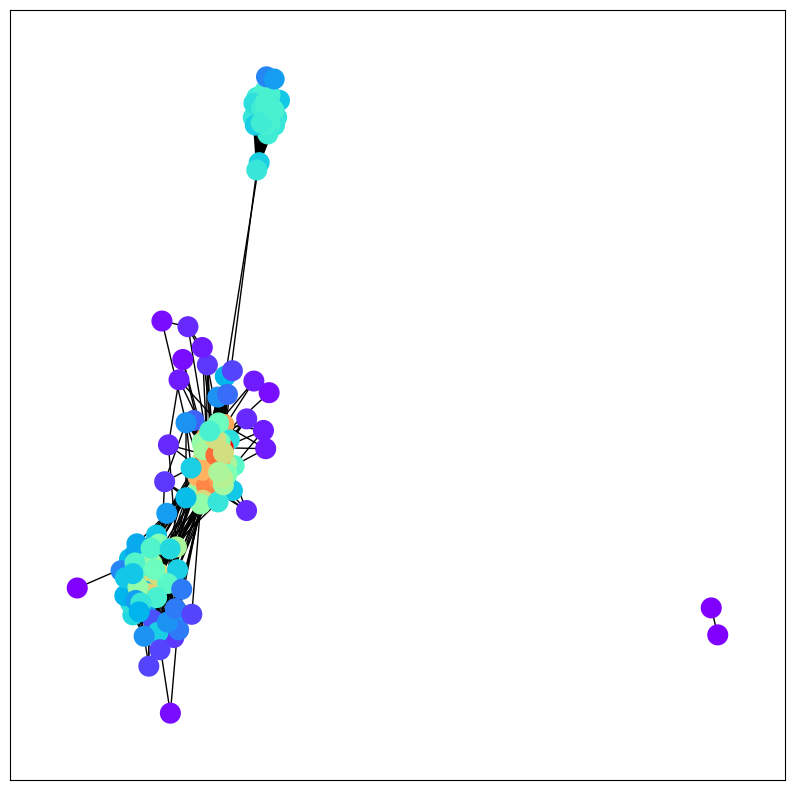

Loading graph from dataset/686.edges


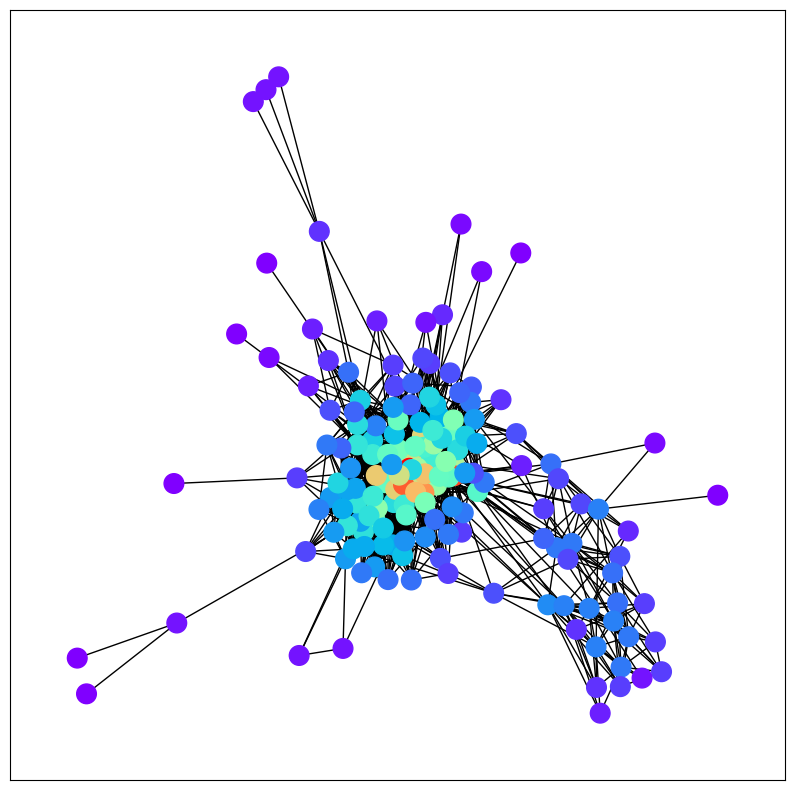

Loading graph from dataset/698.edges


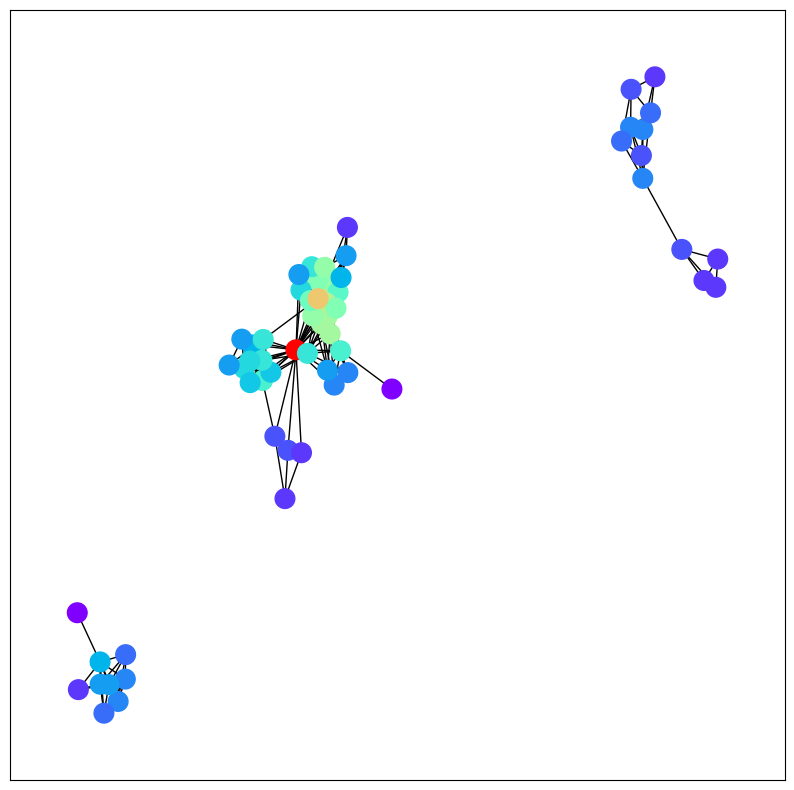

Loading graph from dataset/1684.edges


Loading graph from dataset/1912.edges


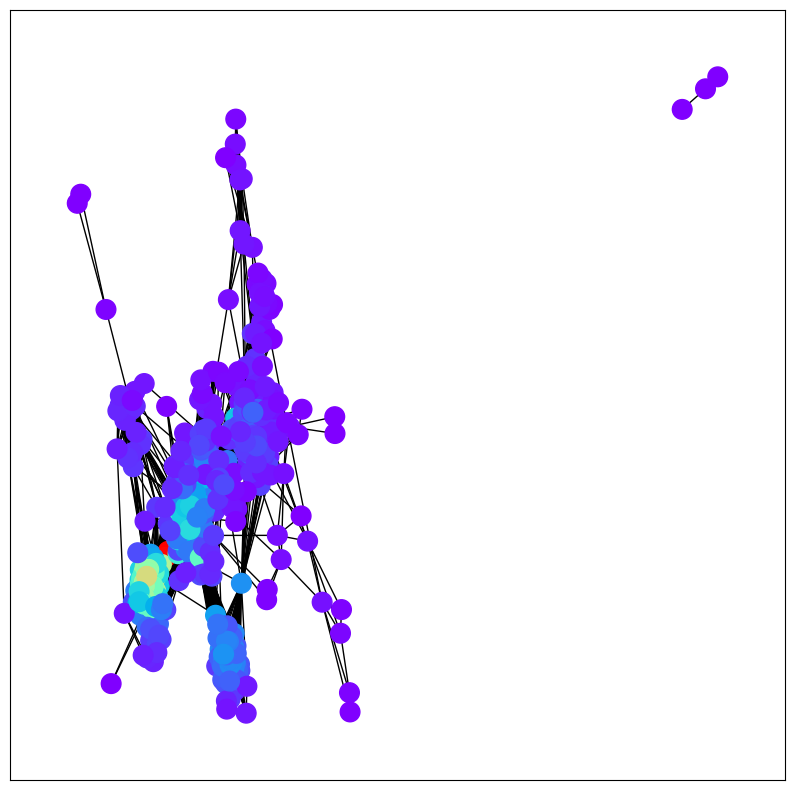

Loading graph from dataset/3437.edges


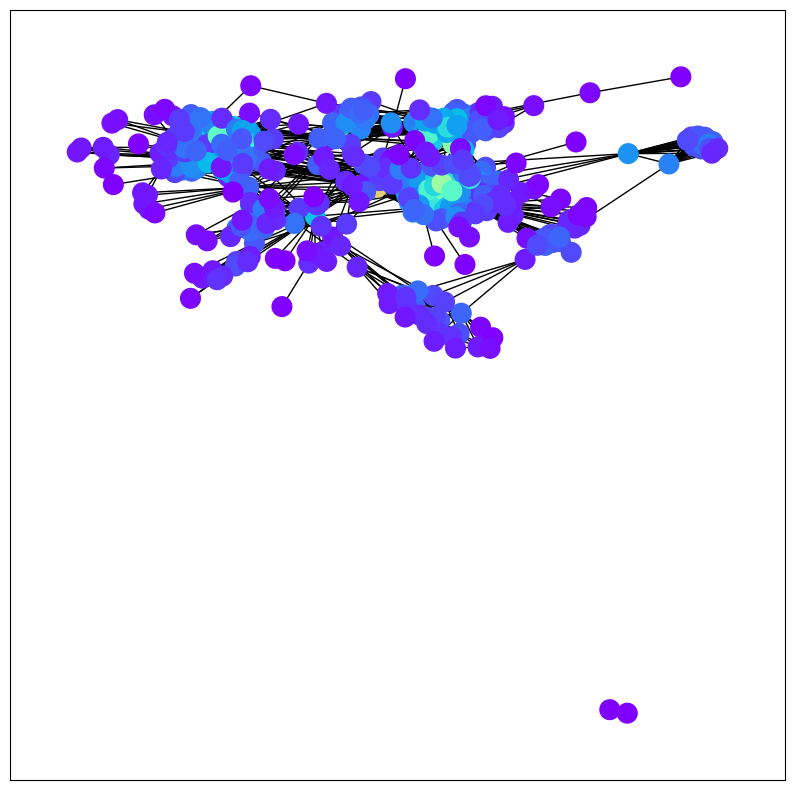

Loading graph from dataset/3980.edges


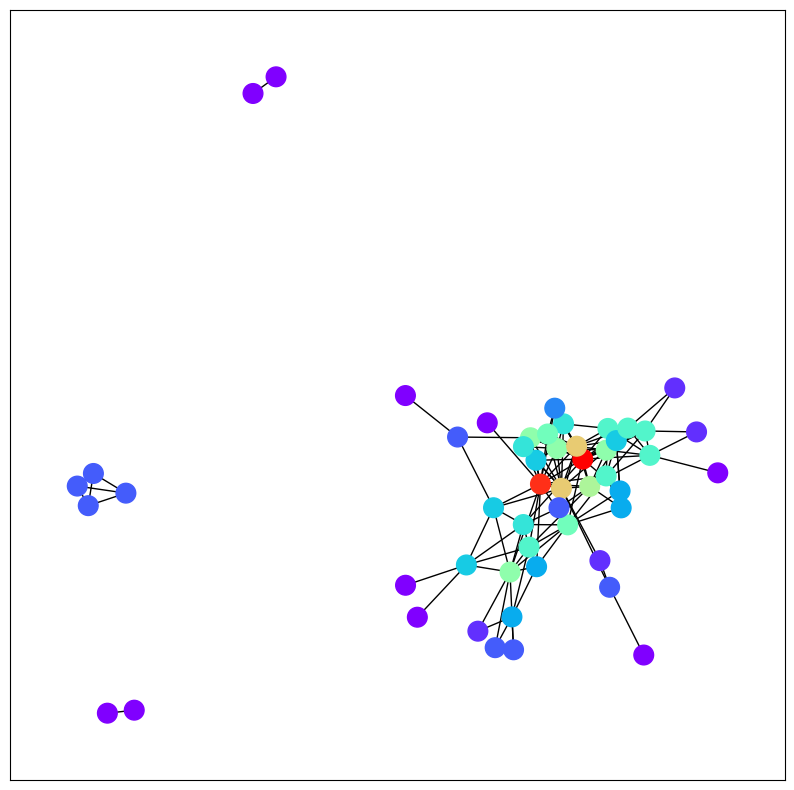

Loading graph from facebook_combined.txt


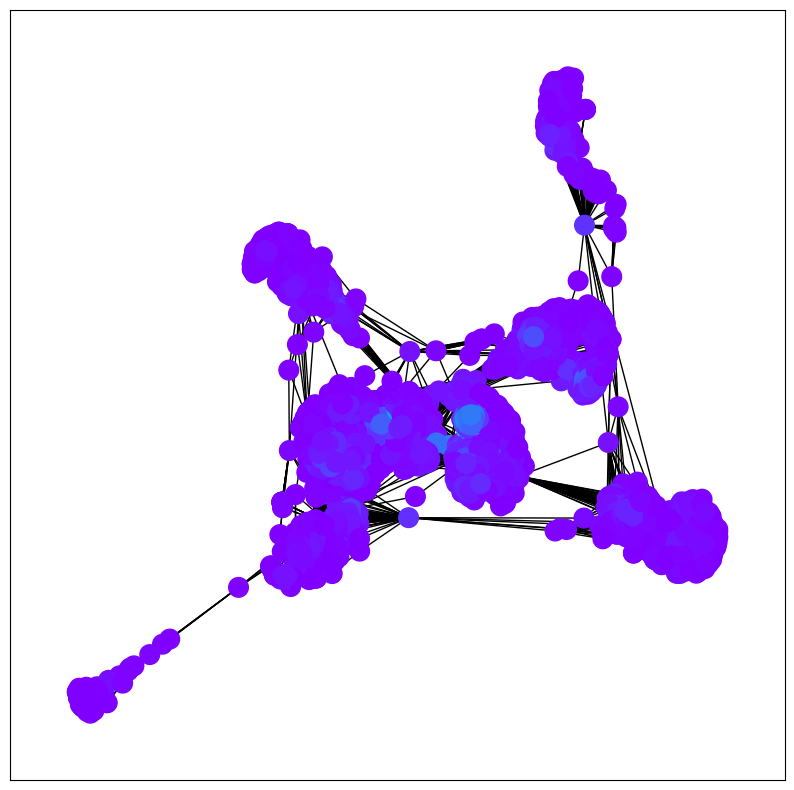

In [23]:
graphs = []
for dataset_path in dataset_paths:
    print(f"Loading graph from {dataset_path}")
    G = load_graph(dataset_path, plot_graph=True)
    graphs.append(G)

# Constructing similarity graph

In [24]:
def construct_similarity_graph(G, similarity_matrix, threshold=0.5, plot_graph=True):
    G_sim = nx.Graph()
    for i, src in enumerate(G.nodes()):
        for j, dst in enumerate(G.nodes()):
            if i != j and similarity_matrix[i, j] > threshold:
                G_sim.add_edge(src, dst, weight=similarity_matrix[i, j])

    if plot_graph:
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G_sim)

        node_color = [20000.0 * G_sim.degree(v) for v in G_sim]

        nx.draw_networkx(
            G_sim,
            pos,
            with_labels=False,
            node_color=node_color,
            node_size=200,
            cmap=plt.cm.rainbow,
        )
        plt.show()
    return G_sim

## Similarity Graphs

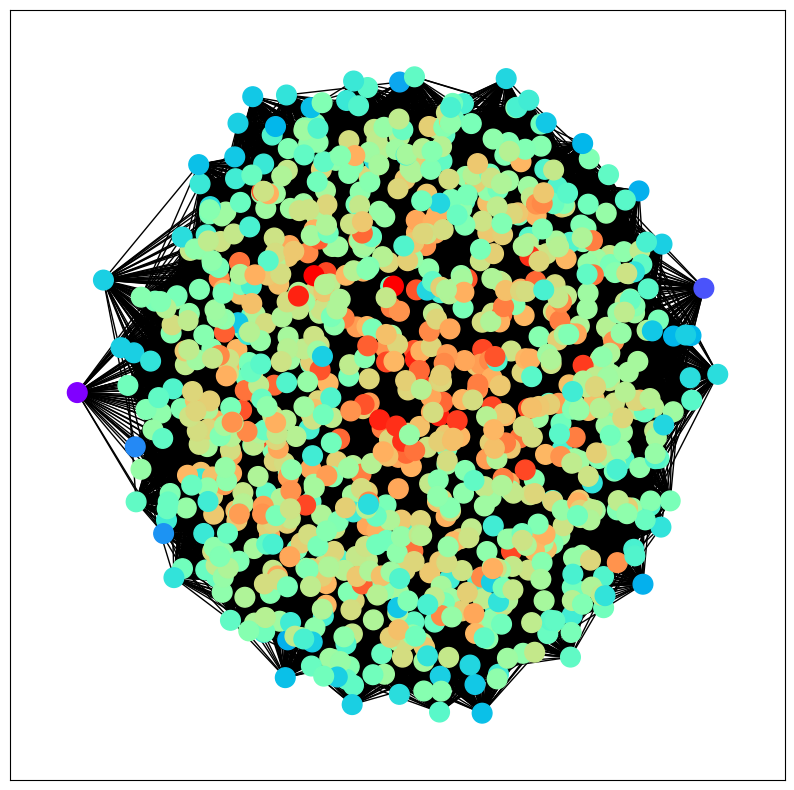

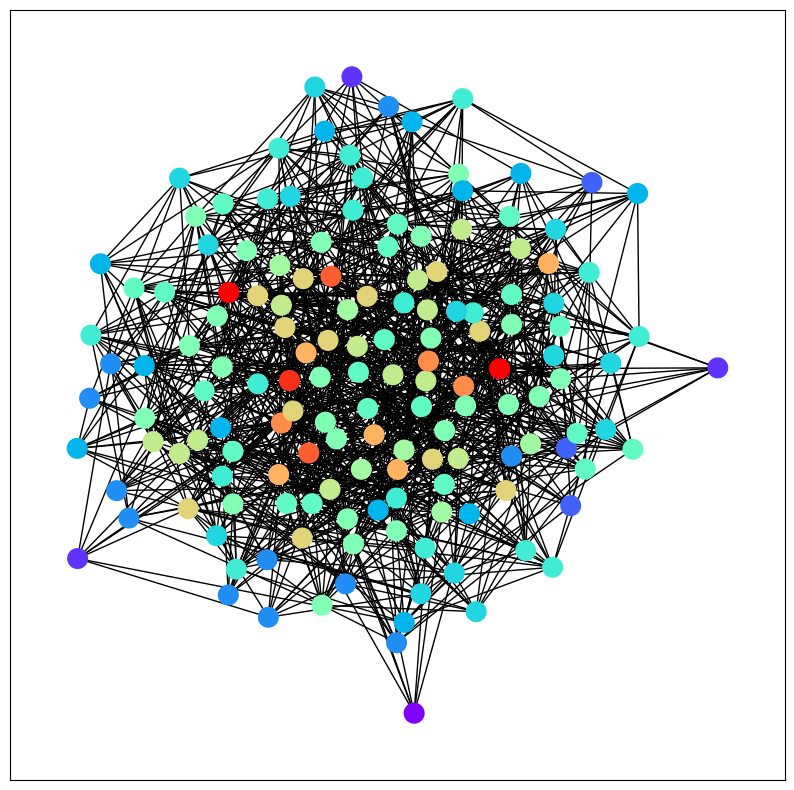

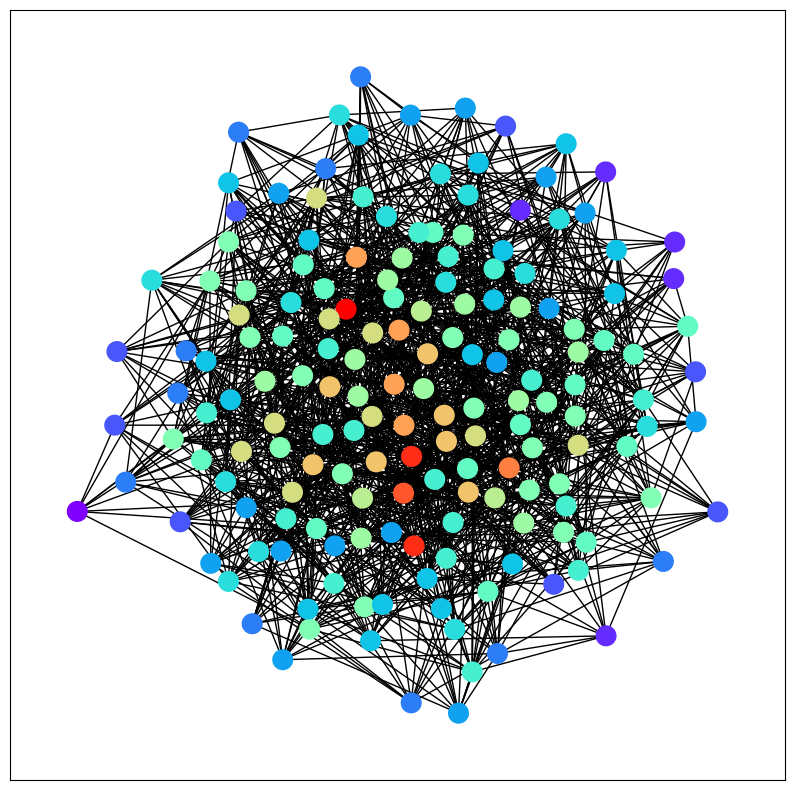

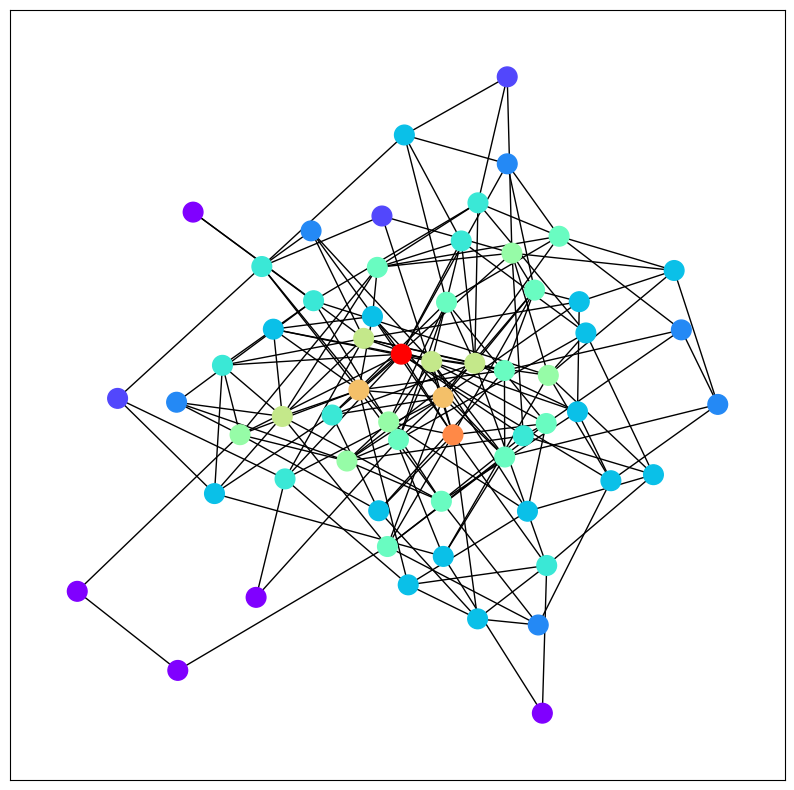

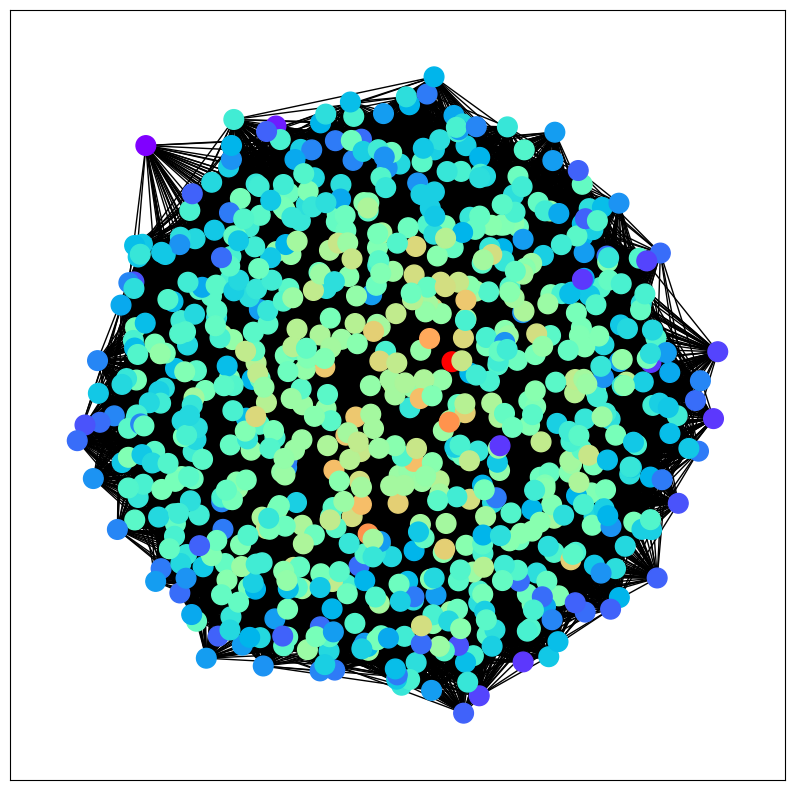

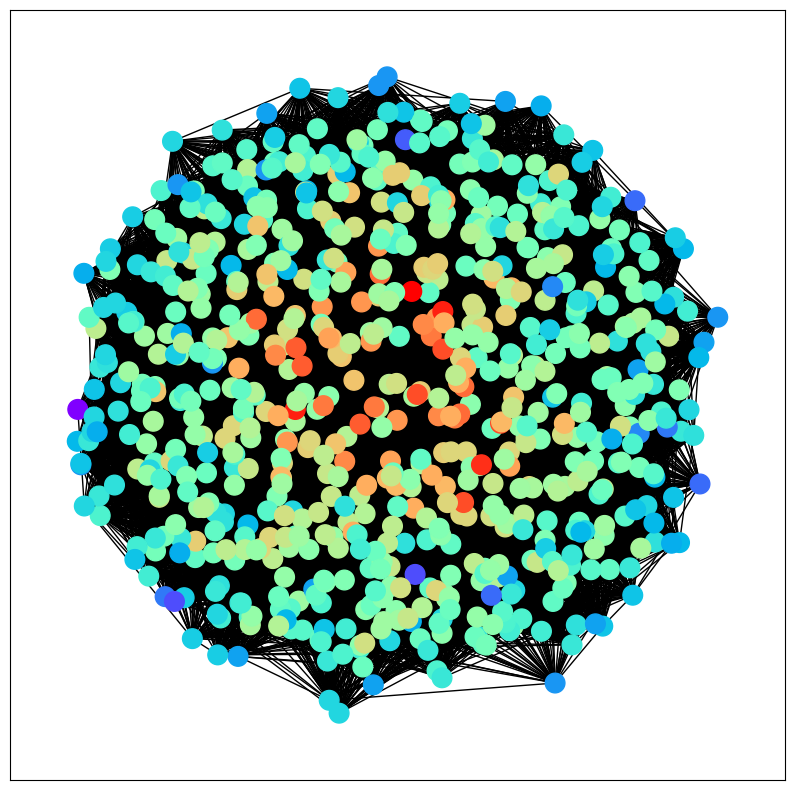

In [25]:
for G in graphs:
    similarity_matrix = np.random.rand(len(G.nodes()), len(G.nodes()))
    G_sim = construct_similarity_graph(G, similarity_matrix, threshold=0.95, plot_graph=True)

# Applying Spectral Clustering

In [36]:
def calculate_laplacian(G):
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    laplacian_matrix = csgraph.laplacian(adjacency_matrix, normed=True)
    return laplacian_matrix

def calulate_eigenvectors(laplacian_matrix, k=2, which="SM"):
    eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)
    return eigenvalues, eigenvectors

def eigen_decoposition(G, k=2, plot_graph=True):
    laplacian_matrix = calculate_laplacian(G)
    adj_mat = nx.adjacency_matrix(G).todense()
    n_components = adj_mat.shape[0]
    eigenvalues, eigenvectors = calulate_eigenvectors(laplacian_matrix, k=n_components, which="SM")
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::][:k]
    nb_clusters = index_largest_gap + 1
    print(f"Number of clusters: {nb_clusters}")

    if plot_graph:
        plt.figure(figsize=(10, 10))
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.title("Eigenvalues of Laplacian matrix")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid()
        plt.show()

    return nb_clusters, eigenvalues, eigenvectors

## Calculating Laplacian Matrix

Loading graph from dataset/0.edges
Loading graph from dataset/107.edges
Loading graph from dataset/348.edges
Loading graph from dataset/414.edges
Loading graph from dataset/686.edges
Loading graph from dataset/698.edges
Loading graph from dataset/1684.edges
Loading graph from dataset/1912.edges
Loading graph from dataset/3437.edges
Loading graph from dataset/3980.edges
Loading graph from facebook_combined.txt


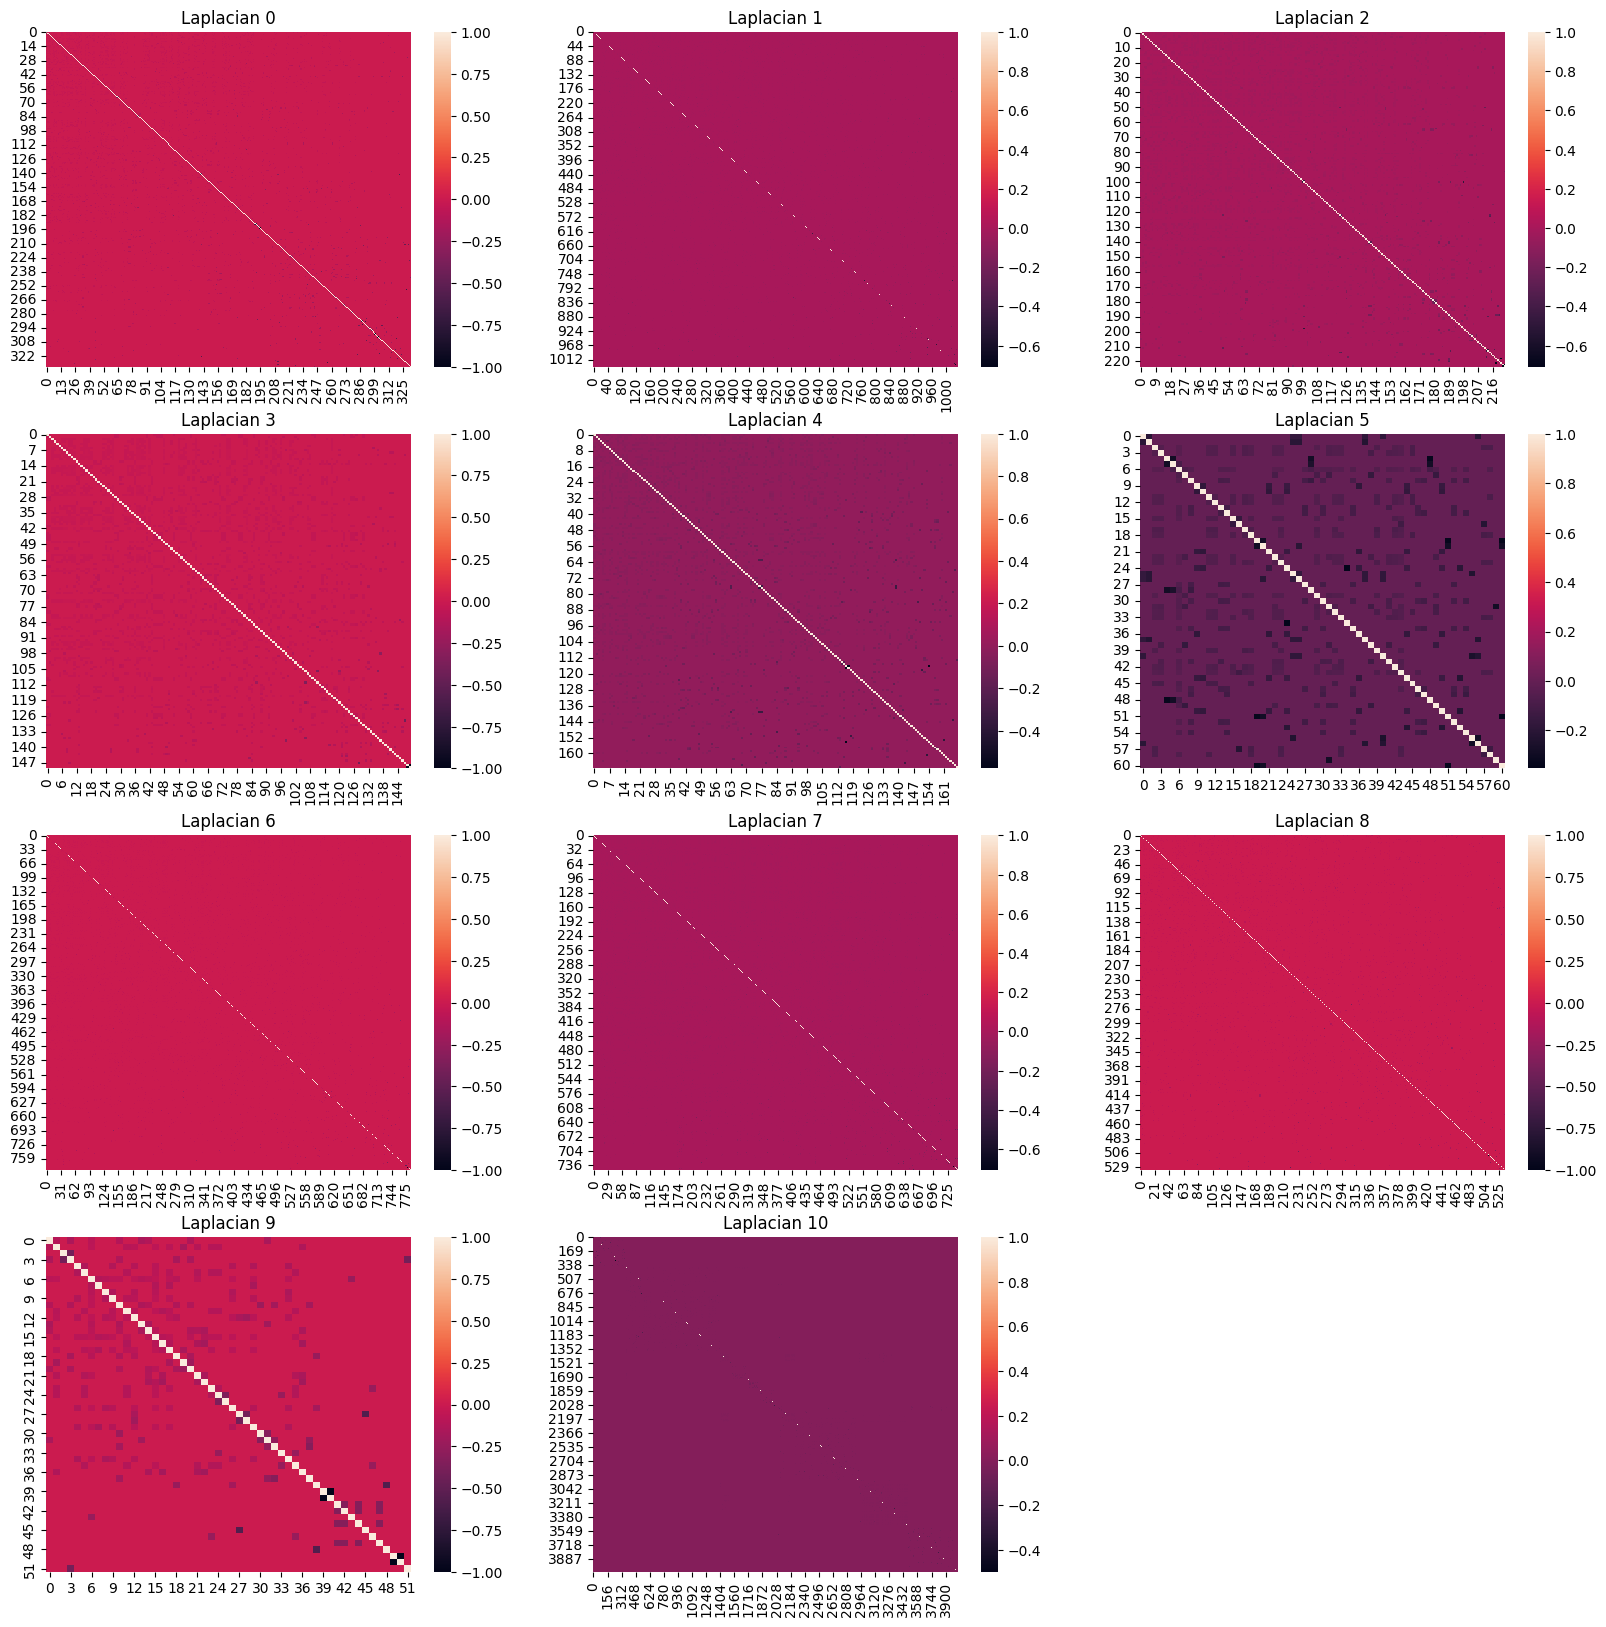

In [37]:
laplacians = []

for dataset_path in dataset_paths:
    print(f"Loading graph from {dataset_path}")
    G = load_graph(dataset_path, plot_graph=False)
    L = calculate_laplacian(G)
    laplacians.append(L)

# plot the laplacian in heatmap in single plot
plt.figure(figsize=(20, 20))
for i, L in enumerate(laplacians):
    plt.subplot(4, 3, i + 1)
    sns.heatmap(L)
    plt.title(f"Laplacian {i}")
plt.show()

## Computing Eigenvectors

Number of clusters: [243 202   2   3   4]


C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


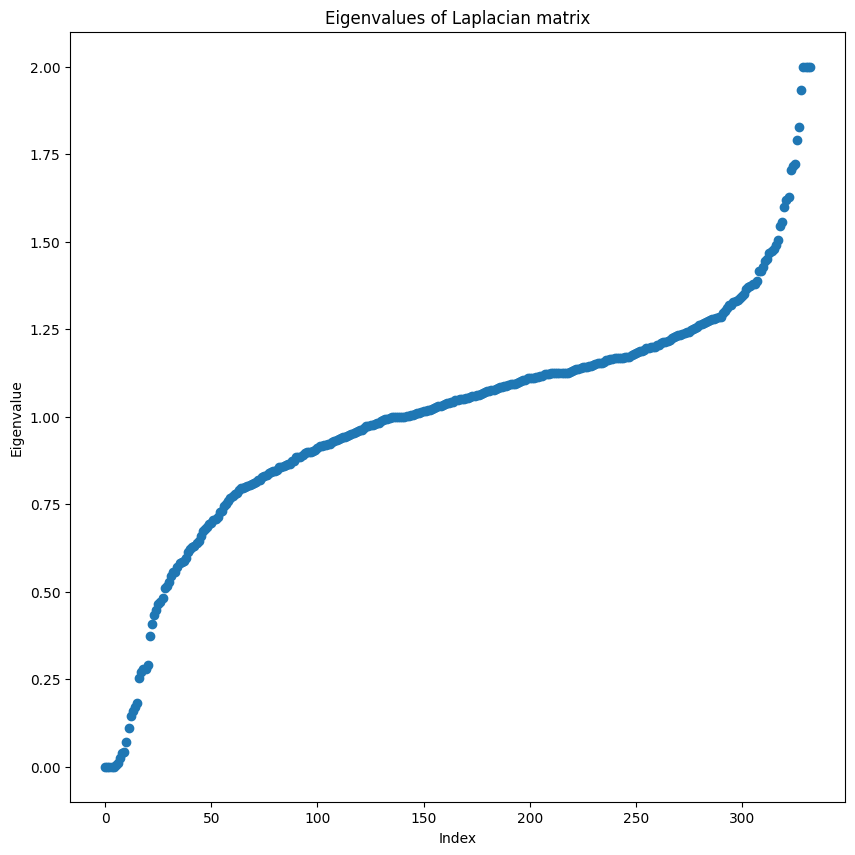

Number of clusters: [1027  982 1026  164  710]


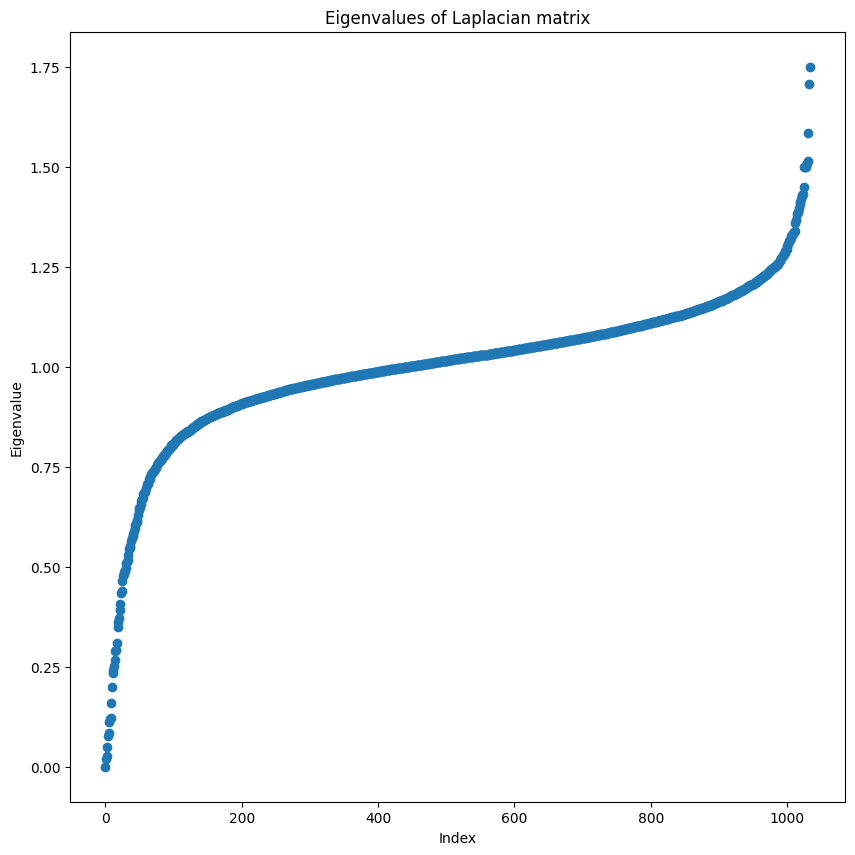

Number of clusters: [216 172  94 107 208]


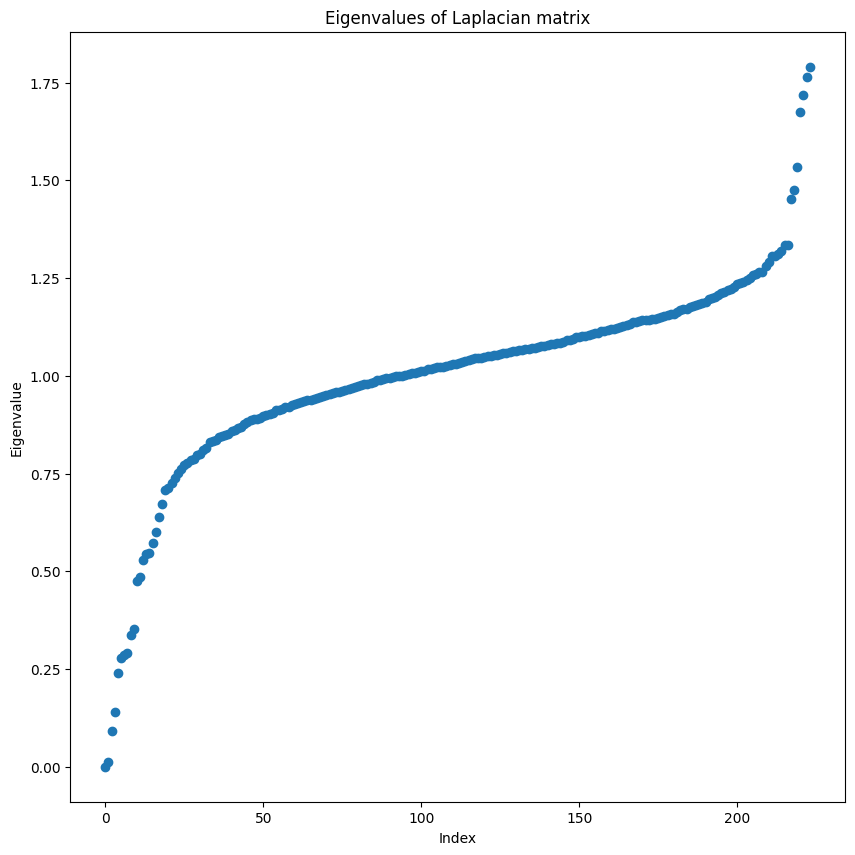

Number of clusters: [ 1 80 79 82 81]


Number of clusters: [157  74  97 108  83]


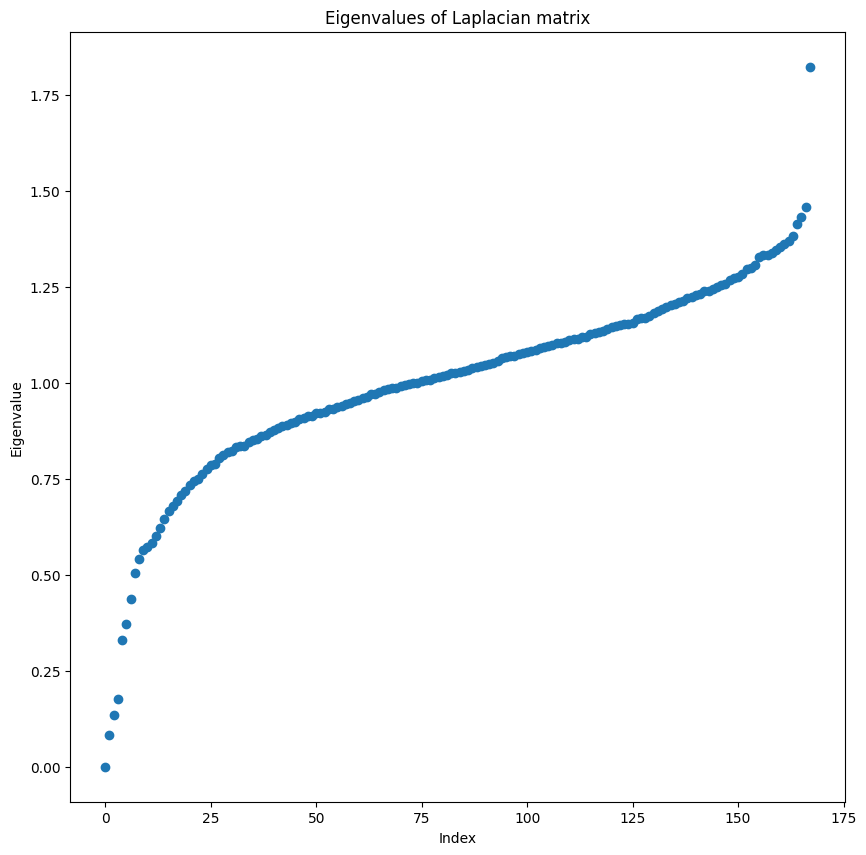

Number of clusters: [ 1  2 54 53 31]


Number of clusters: [589 622   1 619 590]


Number of clusters: [  1 317 426 560 248]


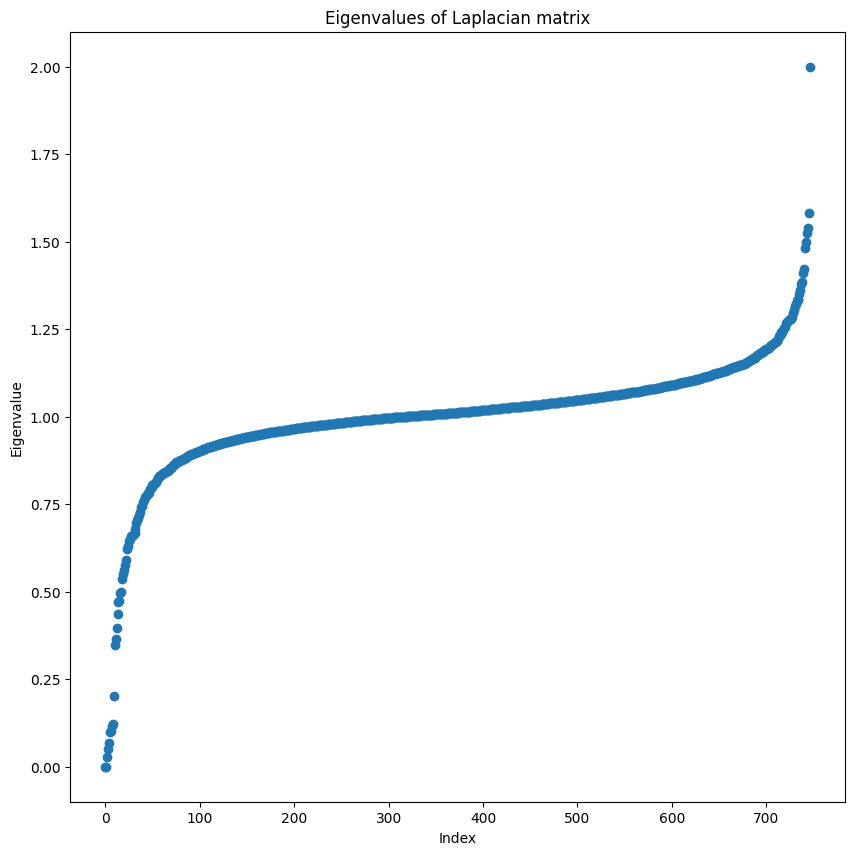

Number of clusters: [307 305 460   1 526]


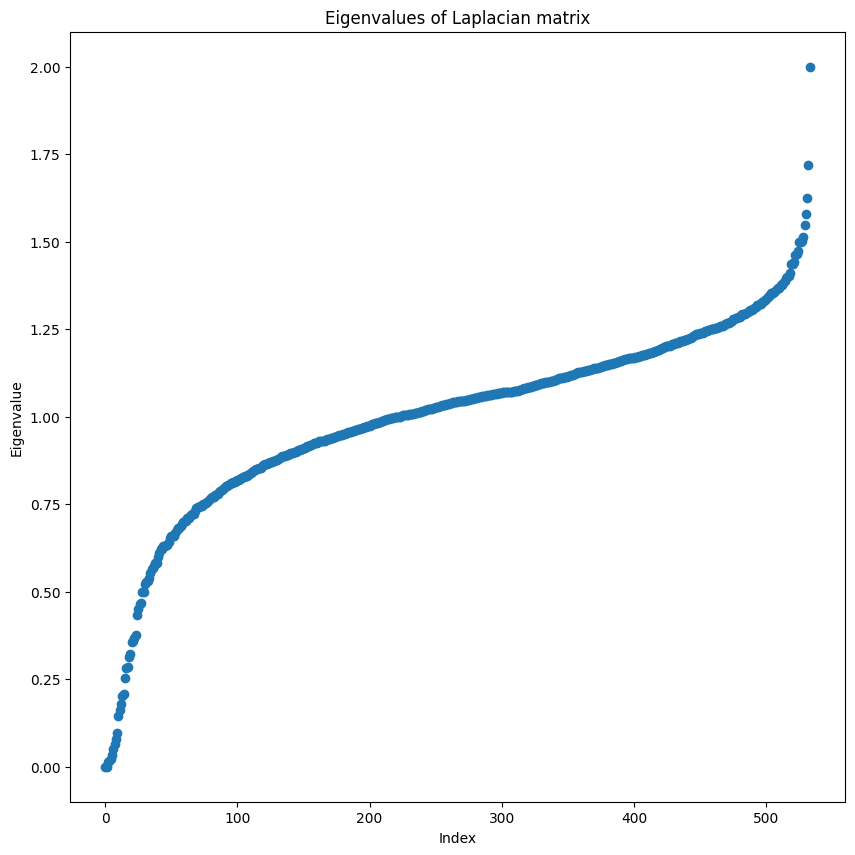

Number of clusters: [ 1  2 38 40 39]


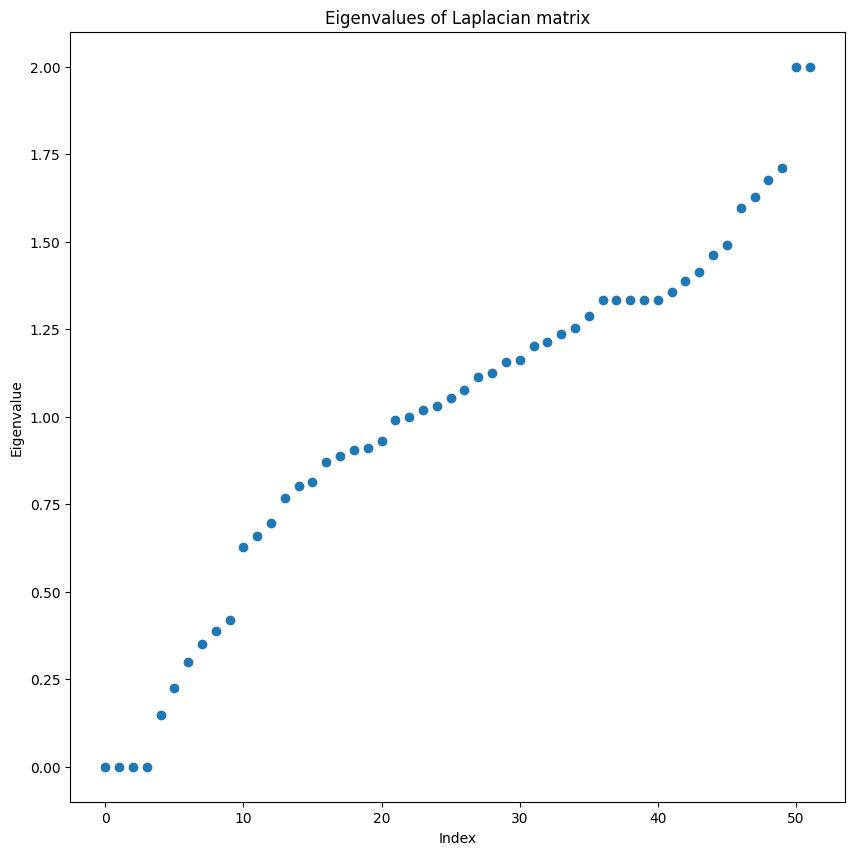

Number of clusters: [1741 3294 3297 3299 3300]


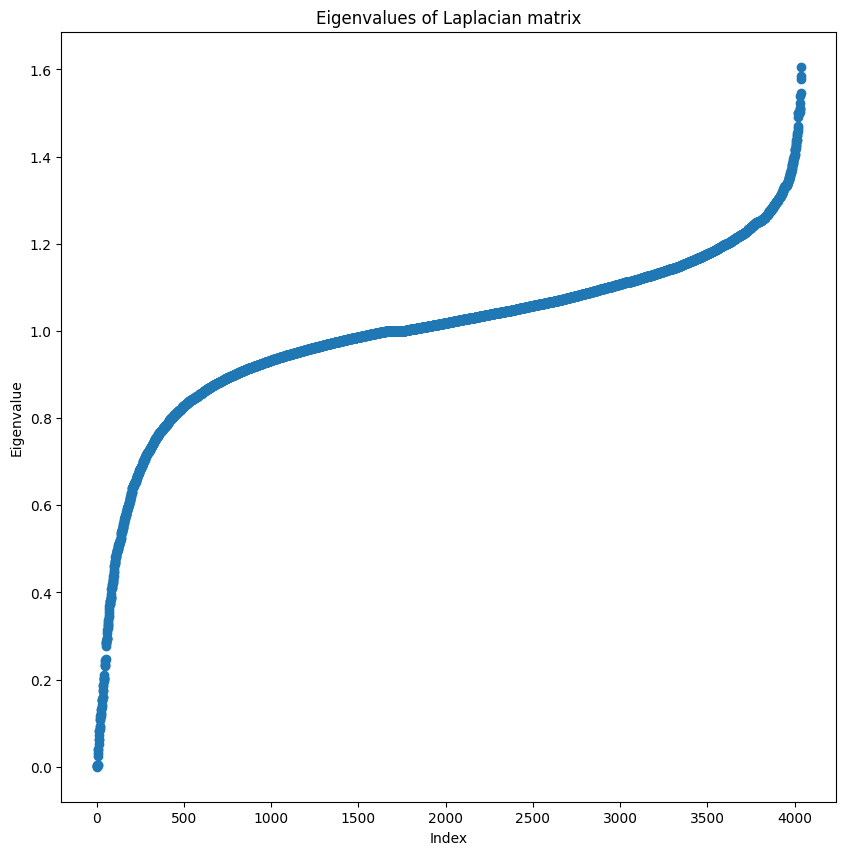

In [39]:
for G in graphs:
    eigen_decoposition(G, k=5, plot_graph=True)

## Implementing Clustering (k-means)

In [48]:
def spectral_clustering_using_k_means(G, k=2, plot_graph=True):
    nb_clusters, eigenvalues, eigenvectors = eigen_decoposition(G, k=k, plot_graph=False)
    kmeans = KMeans(n_clusters=k, random_state=0)

    clusters = kmeans.fit_predict(eigenvectors)

    cluster_mapping = {node: clusters[i] for i, node in enumerate(G.nodes())}

    if plot_graph:
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G)

        nx.draw_networkx(
            G,
            pos,
            with_labels=False,
            node_color=[cluster_mapping[node] for node in G.nodes()],
            node_size=200,
            cmap=plt.cm.rainbow,
        )
        plt.title("Spectral Clustering using KMeans")
        plt.show()

    return clusters


C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [243 202   2   3   4]


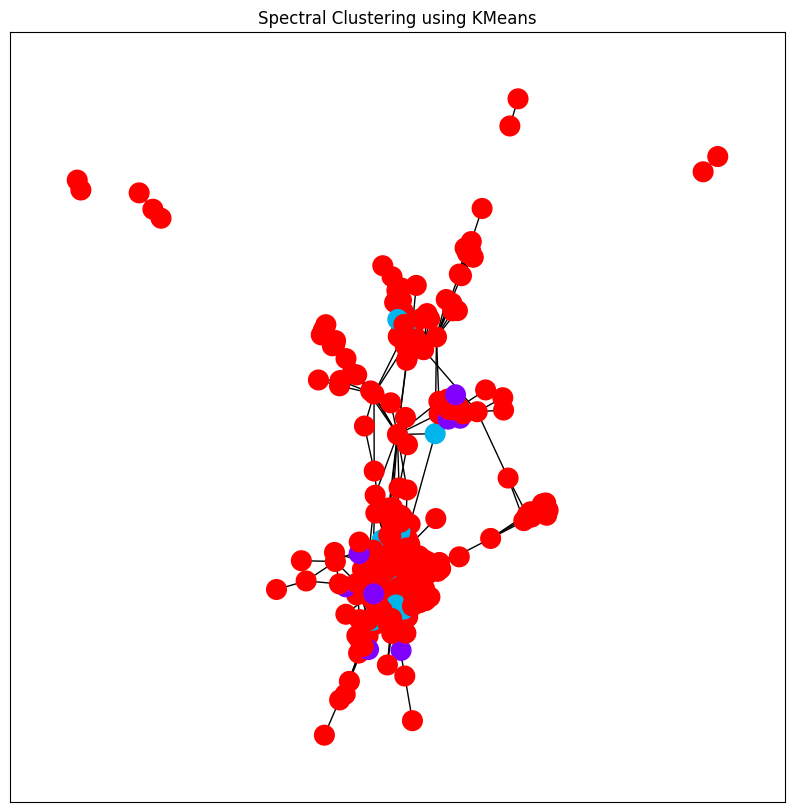

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [1027  982 1026  164  710]


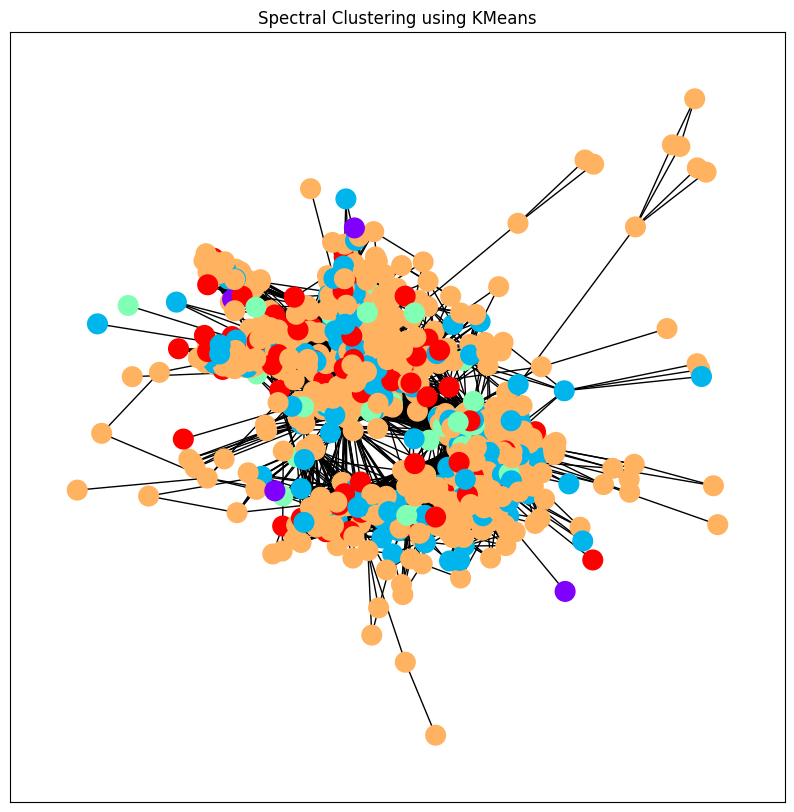

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [216 172  94 107 208]


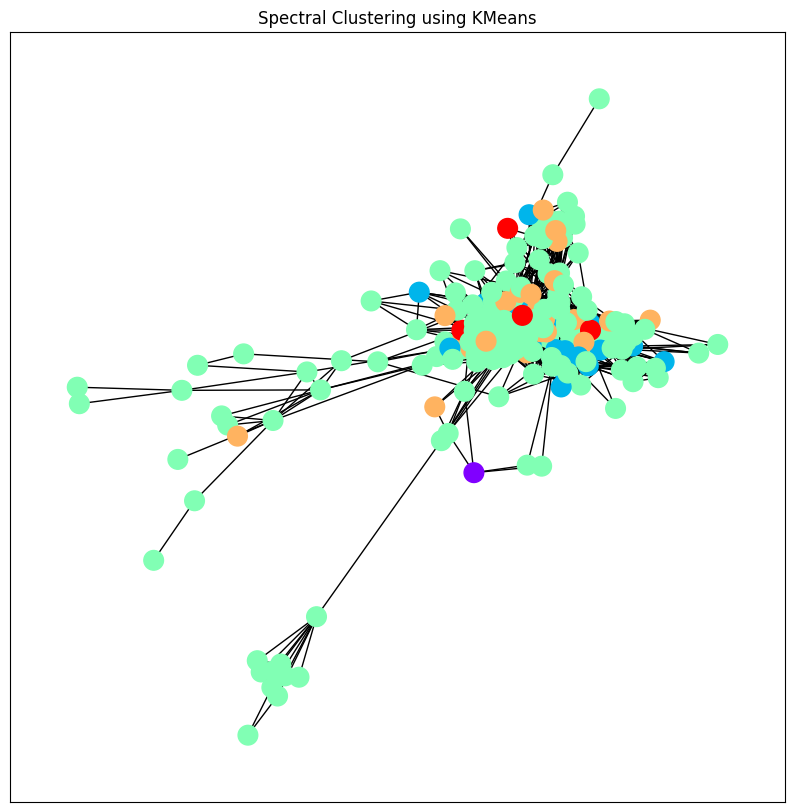

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [ 1 80 79 82 81]


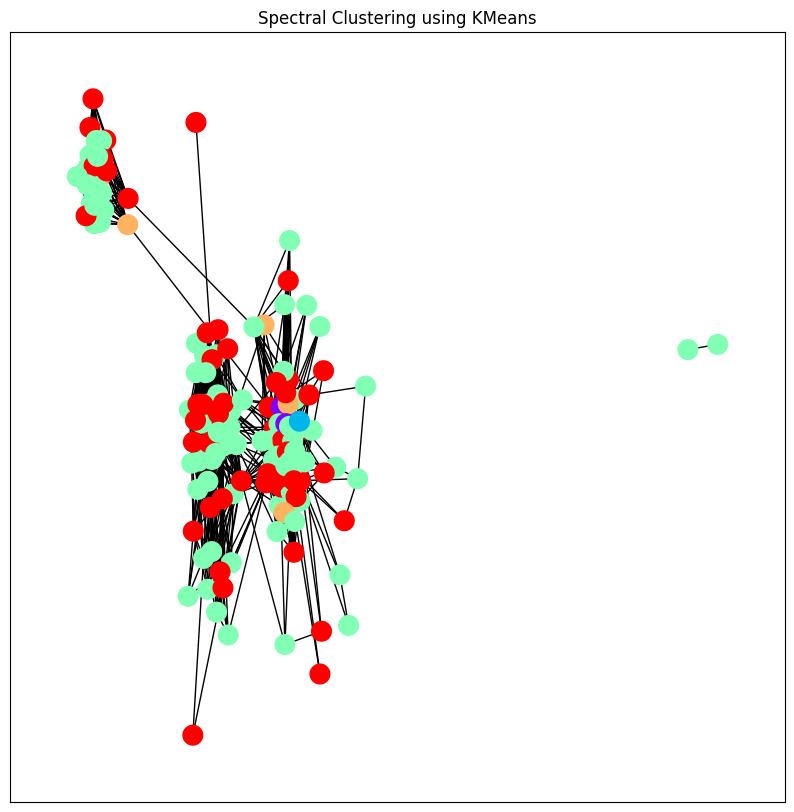

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [157  74  97 108  83]


Number of clusters: [ 1  2 54 53 31]


C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [589 622   1 619 590]


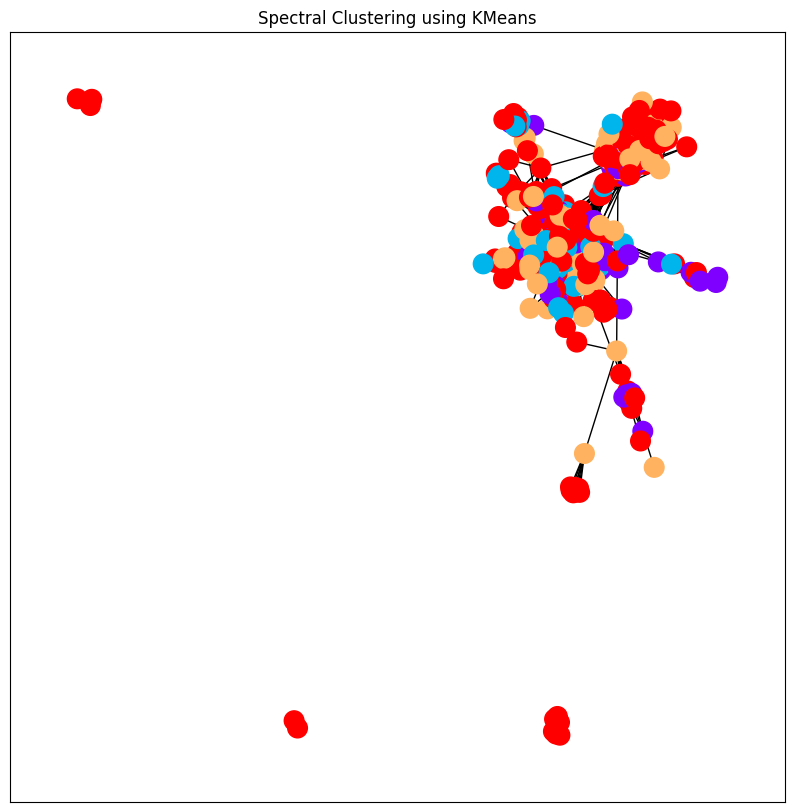

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [  1 317 426 560 248]


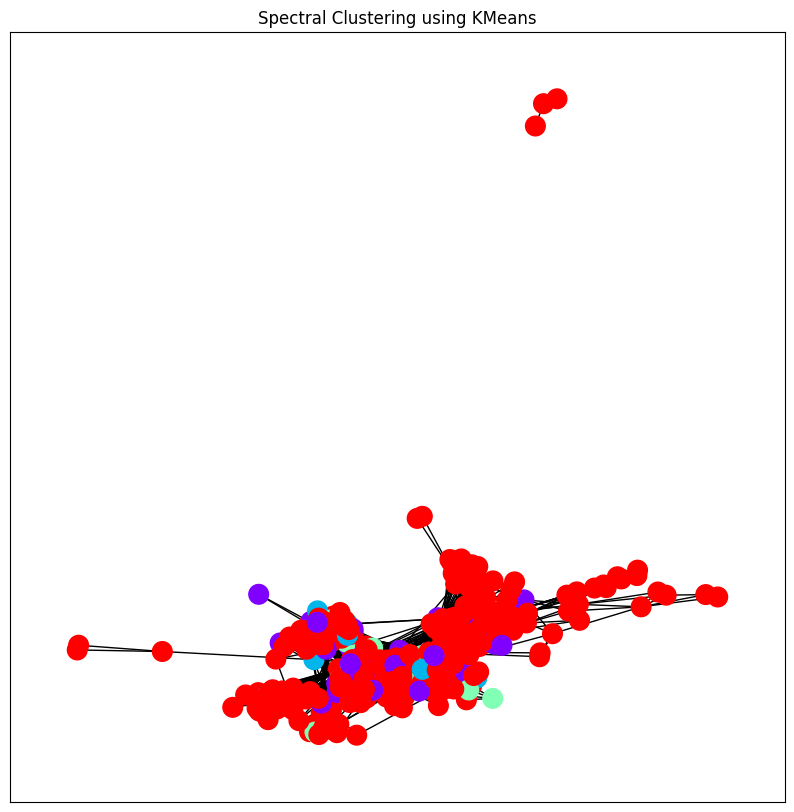

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [307 305 460   1 526]


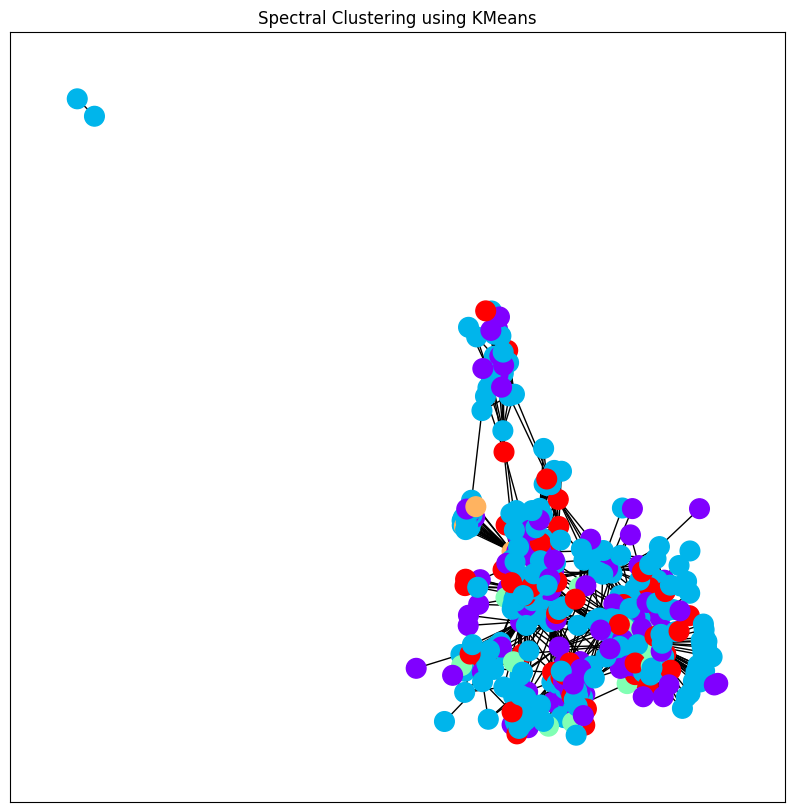

Number of clusters: [ 1  2 38 40 39]


C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


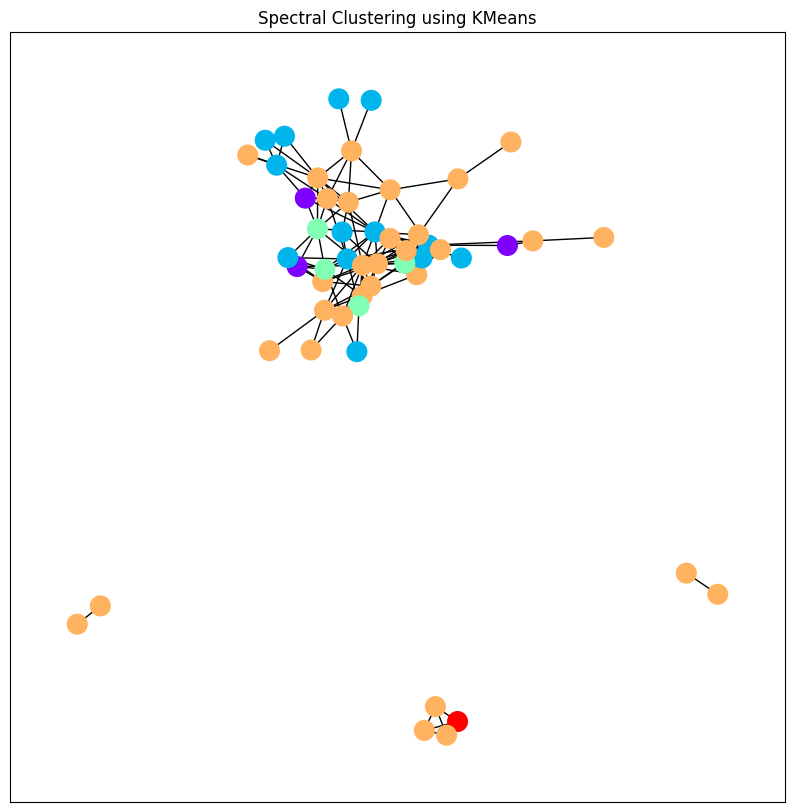

C:\Users\Ahmed Mohiuddin Shah\AppData\Local\Temp\ipykernel_1848\3149818353.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k, which=which)


Number of clusters: [1741 3294 3297 3299 3300]


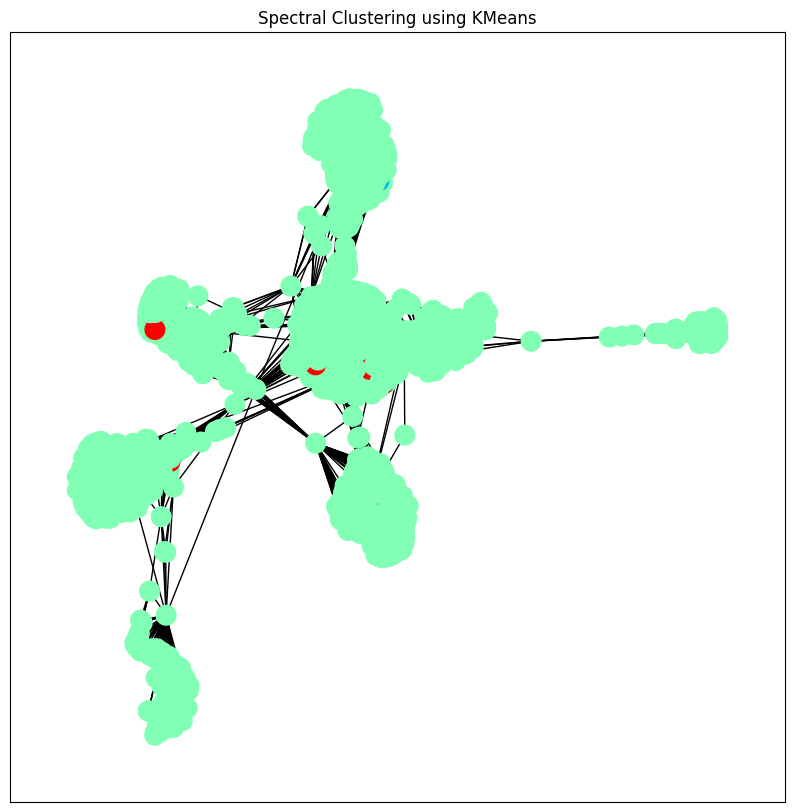

In [51]:
graph_clusters = []

for G in graphs:
    clusters = spectral_clustering_using_k_means(G, k=5, plot_graph=True)
    graph_clusters.append(clusters)